# 6. Parte final - Colocando para jogo

Agora temos um modelo finalizado e em distribuição no MLflow, vamos consumir o modelo e realizar a predição final.

In [41]:
# Importando bibliotecas

# Manipulação de dados
import pandas as pd
import numpy as np 

# Visualização
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import HTML 
import plotly.graph_objects as go 
from pprint import pprint

# Algumas configurações
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuração para o notebook e plotagem de imagens
%matplotlib inline
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    sns.set()

jupyter_settings()



import mlflow
# salvar e carregar modelos
import joblib


# Leitura de arquivos json
import json

# scipy para calcular algumas estatísticas
from scipy.stats import entropy


Para podermos fazer o load do modelo, devemos indicar o caminho, como a seguir:

In [42]:
# Carregando o modelo
mlflow.set_tracking_uri("http://127.0.0.1:8080/")
loaded_model =  mlflow.sklearn.load_model("models:/Churn-Abandono/production")

Agora temos o nosso modelo carregado, é possível visualizar o modelo e ver quais são os inputs.

In [43]:
# Visualizando o modelo
loaded_model

Pipeline(steps=[('preprocesso',
                 ColumnTransformer(transformers=[('std_num', StandardScaler(),
                                                  ['Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('robust', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts'])])),
                ('clf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=10, min_samples_leaf=4,
                                        n_estimators=600, random_state=42))])

O `input_schema` é uma estrutura de dados que contêm diversas informações sobre o modelo, alguns exemplos são:


In [44]:
model_info = mlflow.models.get_model_info("models:/Churn-Abandono/production")
features = [i['name'] for i in json.loads(model_info.signature_dict['inputs'])]
features

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

Carregando o nosso bando de dados para o teste final

In [45]:
df = pd.read_csv("../data/Abandono_teste.csv", sep=";")

df_test_final = df.copy()
# Removendo as colunas desnecessárias 
df_test_final.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True) 
df_test_final.head(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,565,France,Male,31,1,0.00,1,0,1,20443.08
1,569,France,Male,34,4,0.00,1,0,1,4045.90
2,669,France,Female,20,7,0.00,2,1,0,128838.67
3,694,France,Male,39,4,173255.48,1,1,1,81293.10
4,504,Spain,Male,28,10,109291.36,1,1,1,187593.15
5,776,France,Male,29,4,0.00,2,0,1,88440.83
6,585,France,Male,25,7,159301.00,1,1,1,39824.96
7,651,Germany,Male,24,5,158484.85,1,1,1,161234.90
8,672,France,Male,45,7,0.00,2,0,0,174177.96
9,527,France,Male,23,8,0.00,2,1,0,76589.04


In [46]:
# prevendo e colocando o resultado no conjunto
df_test_final['predictedValues'] = loaded_model.predict(df_test_final[features])

# Colocando as probabilidades do modelo para cada classe
df_test_final['Proba_0'] = loaded_model.predict_proba(df_test_final)[:,0]
df_test_final['Proba_1'] = loaded_model.predict_proba(df_test_final)[:,1]

# # Checando o resultado com as respectivas probabilidades 
df_test_final[['predictedValues', 'Proba_0', 'Proba_1']]


,predictedValues,Proba_0,Proba_1
0,0,0.861637,0.138363
1,0,0.877416,0.122584
2,0,0.972964,0.027036
3,0,0.890919,0.109081
4,0,0.916497,0.083503
...,...,...,...
995,0,0.849789,0.150211
996,1,0.162029,0.837971
997,1,0.253234,0.746766
998,0,0.990550,0.009450


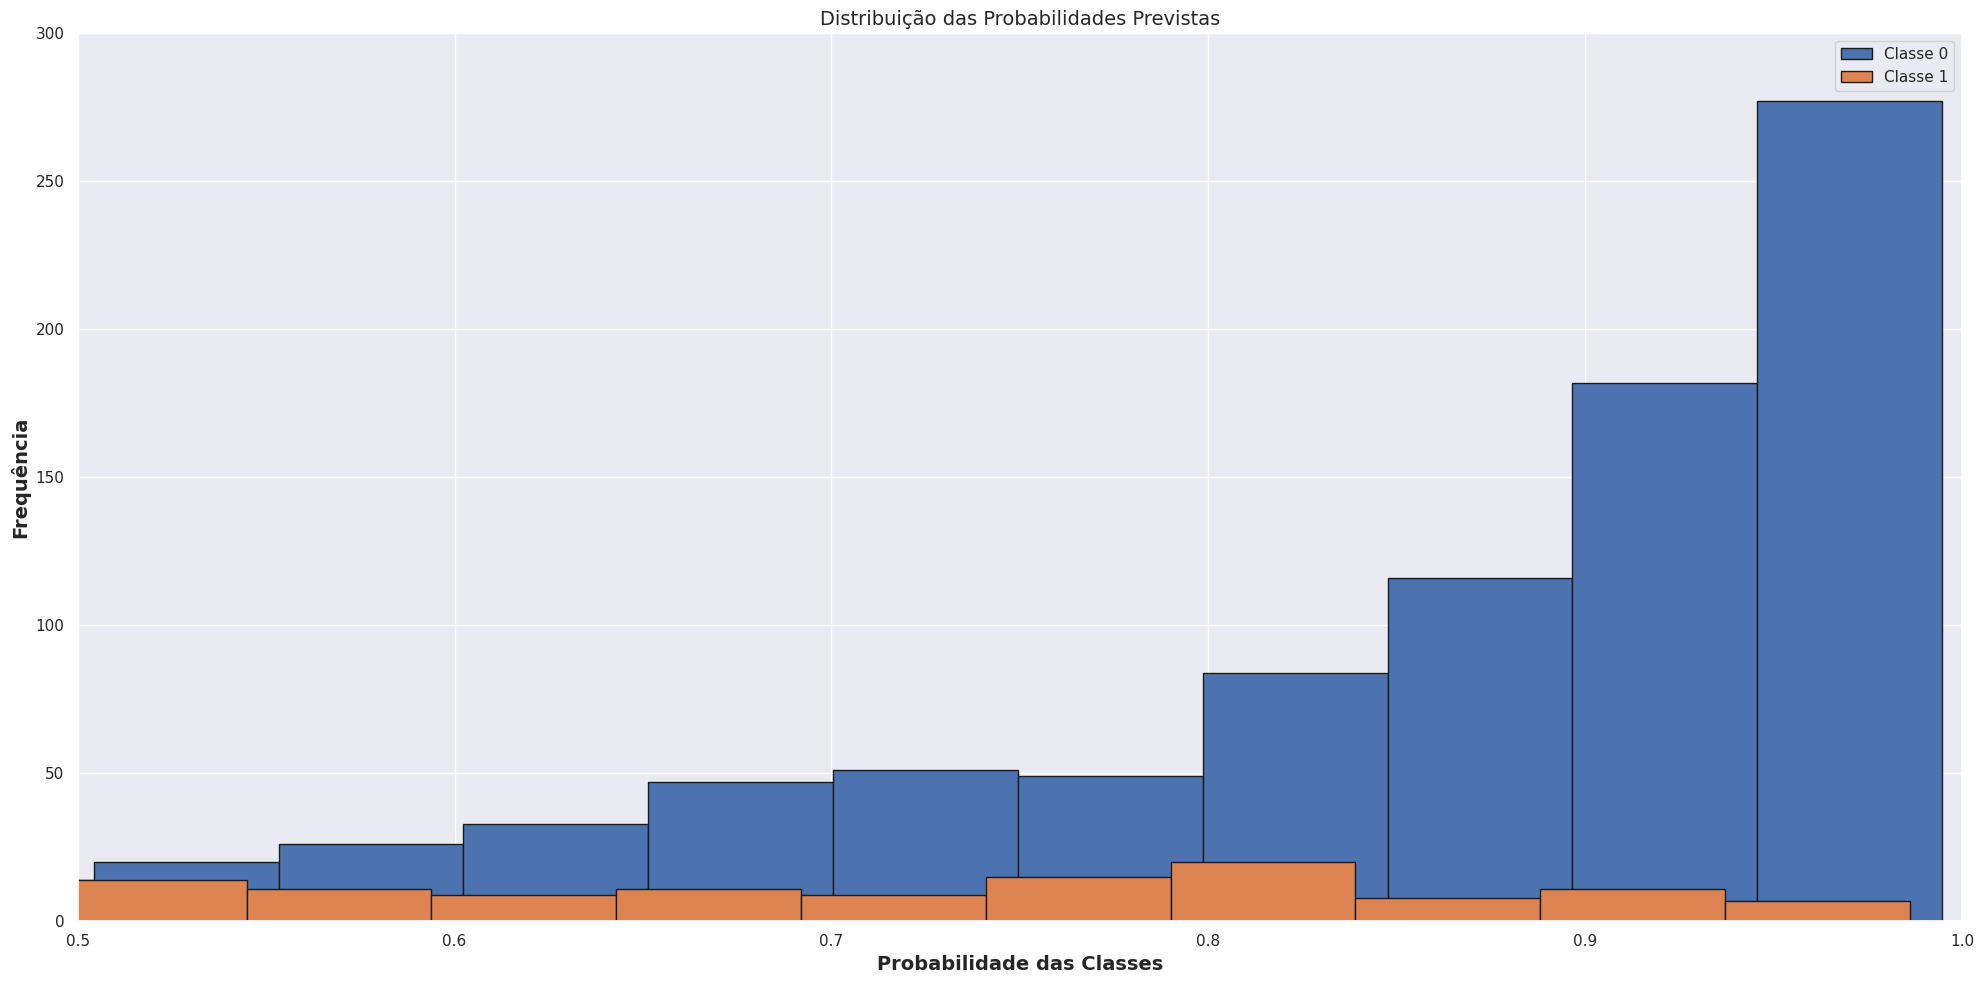

In [52]:
fig = plt.figure( figsize=(20, 10))  
# Histograma das probabilidades
plt.hist(df_test_final['Proba_0'], bins=20, edgecolor='k', label='Classe 0')
plt.hist(df_test_final['Proba_1'], bins=20, edgecolor='k', label='Classe 1')
plt.title("Distribuição das Probabilidades Previstas",fontsize=14)
plt.xlabel("Probabilidade das Classes",fontsize=14,  fontweight='bold')
plt.legend()
plt.xlim(0.5,1)
plt.ylim(0,300)
plt.ylabel("Frequência", fontsize=14,  fontweight='bold')
plt.tight_layout()
plt.savefig("../imagens/dist_prob_previstas.png")
plt.show()

Estes valores no indicam que o nosso modelo por mais que realize as predições, é possível notar que para classe majoritária (Classe $0$), mais de $50\%$ das predições foram feitas com uma probabilidade entre $90\%$ à $100\%$. Já na classe minoritária, não temos o mesmo cenário. Cada intervalo de $10\%$ representam por volta de $20\%$ dos dados previsto, o que nos levar a dizer que o nosso modelo ainda precisa de ajustes.

In [48]:
# Calcular a entropia para cada previsão
probabilidades = loaded_model.predict_proba(df_test_final[features])
entropias = entropy(probabilidades, axis=1)

# Média da entropia
media_entropia = np.mean(entropias)
print(f"Entropia média das previsões: {media_entropia:.2f}")

Entropia média das previsões: 0.37


In [58]:
# Contagem por classe
classes, counts = np.unique(df_test_final['predictedValues'], return_counts=True)
for c, count in zip(classes, counts):
    print(f"Classe {c}: {count} previsões")
print(f"A taxa de Churn é de {counts[1]/counts.sum() *100}%!")


Classe 0: 886 previsões
Classe 1: 114 previsões
A taxa de Churn é de 11.4%!


In [50]:
print(f"Média das Previsões: {np.mean(df_test_final['predictedValues']):.2f}")
print(f"Desvio Padrão das Previsões: {np.std(df_test_final['predictedValues']):.2f}")

Média das Previsões: 0.11
Desvio Padrão das Previsões: 0.32


Alguns outros valores que podemos obter:

- Entropia média das previsões: 0.37.
Este valor nos indica a incerteza das previsões, quanto mais próximo de $0$ mais certo o modelo, o nosso valor está abaixo do $0.5$, indicando que a maioria das previsões tem probabilidades longe de $0.5$, indicando confiança, contudo este valor nos sugere que o modelo ainda precisa ser aprimorado.

In [51]:
Abandono_clientes_final = pd.DataFrame({'RowNumber':df['RowNumber'],
             'predictedValues': df_test_final['predictedValues']})
Abandono_clientes_final

,RowNumber,predictedValues
0,10001,0
1,10002,0
2,10003,0
3,10004,0
4,10005,0
...,...,...
995,10996,0
996,10997,1
997,10998,1
998,10999,0


Obs.: A versão do scrip em python deste notebook está na pasta `scr`.